In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random as random_sparse

In [2]:
# implementing l1 procrustes loss with irls/weighted majorization
# from https://link.springer.com/chapter/10.1007%2F3-540-27373-5_18

# Finding T which minimizes sum i,j abs(e_i,j), where E = Y - XT
# if no initial T input, it is random normal
def l1proc_min(X, Y, num_iters, T_init=None, perturb=True):
    n, k = X.shape
    if T_init is None:
        T_0 = np.random.normal(size=(k,k))
    else:
        T_0 = T_init
    err = np.zeros((num_iters))
    
    for curr_it in range(num_iters):
        if perturb:
            if curr_it > 0:
                noise = np.random.normal(scale=1/((curr_it+1)**2), size=(Y.shape)) # smaller variance each iter
            else:
                noise = 0
        else:
            if curr_it > 0:
                noise = 0
            else:
                noise = np.random.normal(size=(Y.shape))
            
        E_0 = (Y - X.dot(T_0)) + noise # adding random noise to error matrix - seems to help with local minima
        if np.any(E_0 == 0):
#             print('zero error on iter:' + str(curr_it))
            return T_0, err
        
        W = 1 / np.abs(E_0)
        err[curr_it] = np.abs(E_0).sum()
        
        D_m = np.diag(W.max(axis=1))   
        weight = np.divide(W, W.max(axis=1).reshape((n,1)))
        R = np.multiply((1 - weight), X.dot(T_0)) + np.multiply(weight, Y)
        
        S = np.dot(np.dot(np.transpose(X), D_m), R)
        U, sig, V_T = np.linalg.svd(S)
        T = U.dot(V_T)
        T_0 = T
    return T_0, err


# Orthogonal procrustes l2 soln
def l2proc_min(X, Y):
    M = X.T.dot(Y)
    U, S, V_T = np.linalg.svd(M)
    T = U.dot(V_T)
    return T


# function to do a warm start
def warm_start_IRLS(num_iter, X, Y, T_l1_lowest, lowest_err, perturb=True):
    errs = np.array([])
    for i in range(num_iter):
        T_l1, err = l1proc_min(X, Y, num_iters=50, T_init=T_l1_lowest, perturb=perturb)
        E_l1 = Y - X.dot(T_l1)
        nonzero_min = err[np.nonzero(err)[-1][-1]]
        np.append(errs, np.sum(np.abs(E_l1)))
        if nonzero_min < lowest_err:
            print('curr err:\t' + str(nonzero_min))
            if lowest_err - nonzero_min < .1:
                print('small decrease in error. stopping.')
                break
            else:
                T_l1_lowest = T_l1
                lowest_err = nonzero_min
                E_l1_lowest = E_l1
                errs = np.append(errs, err)
        else:
            print('increase err:\t' + str(nonzero_min))  # keep going to possibly get out of local minima
    #         if lowest_err - nonzero_min < 1:
    #             break
    #         print('increase in error. stopping.')
    #         break
    return T_l1_lowest, E_l1_lowest, errs
    

In [3]:
%%time
# modeling sparse errors for XT - Y = E
# X = (E + Y)T^-1
n, k = 100, 100
sparse_mat = random_sparse(n, k, density=1/100)
E = sparse_mat.A
T_true, _ = np.linalg.qr(np.random.normal(size=(k,k)))  # T is orthogonal
Y = np.random.normal(size=(n,k))
X = np.dot(E + Y, T_true.T)
print('True err:\t' + str(np.abs(E).sum()))

# L2 soln
T_l2 = l2proc_min(X, Y)
E_l2 = Y - X.dot(T_l2)
print('l2 err:\t\t', np.sum(np.abs(E_l2)))

# init with l2 soln
errs = np.array([])
T_l1_lowest = T_l2
lowest_err = np.sum(np.abs(E_l2))


T_l1_lowest, E_l1_lowest, errs = warm_start_IRLS(100, X, Y, T_l2, lowest_err, perturb=True)

True err:	54.690021507297466
l2 err:		 265.8320542562844
curr err:	227.49481424260526
curr err:	202.54320447597354
curr err:	184.85444586090676
curr err:	168.9698276908555
curr err:	156.26134137355453
curr err:	142.68260177450472
curr err:	130.1679498924173
curr err:	119.6517224924869
curr err:	110.63655139748928
curr err:	101.91262966873646
curr err:	94.91390903033181
curr err:	87.77711271666269
curr err:	82.29298902287788
curr err:	78.20206663787076
curr err:	73.90965610995883
curr err:	70.71095128534336
curr err:	67.86816752860601
curr err:	65.7768072400637
increase err:	68.27525724147687
curr err:	64.4228860622776
curr err:	63.59274142951139
curr err:	62.72980212226617
increase err:	64.19966057374151
curr err:	62.10570903900483
increase err:	62.22307844071527
increase err:	62.18416404087739
curr err:	61.7710484363089
curr err:	61.52090928241749
curr err:	61.48378165619705
small decrease in error. stopping.
Wall time: 4.56 s


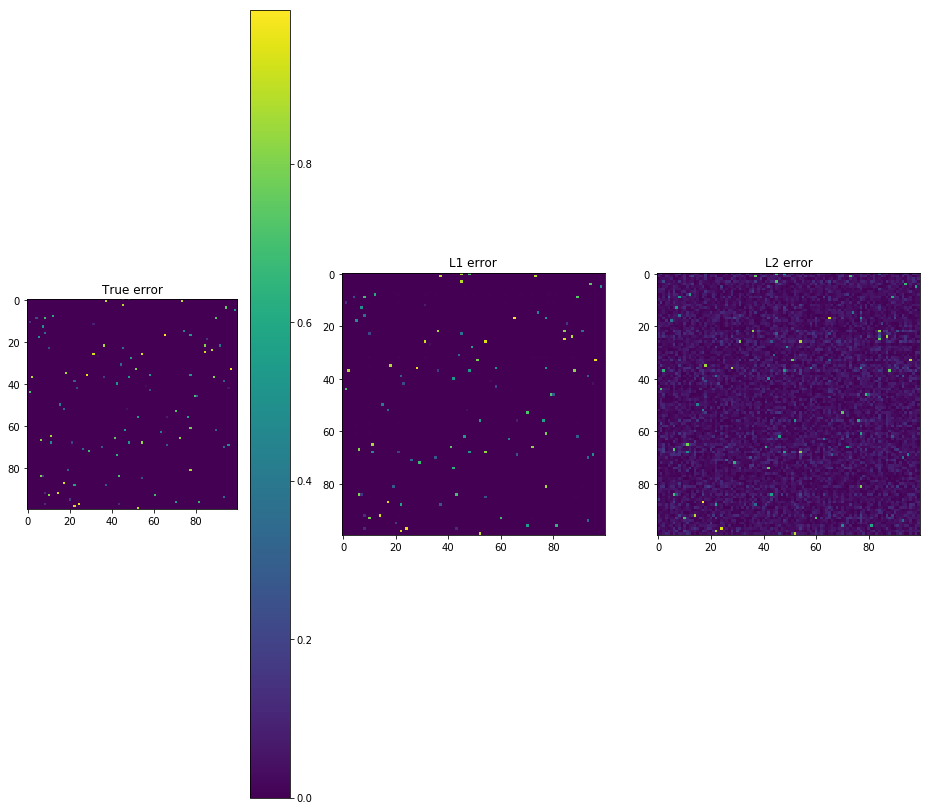

In [4]:
# Visualizing the true sparse error we generated
# Along with the L2 solution error and our L1 solution error
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
im = ax[0].imshow(np.abs(E)) 
fig.colorbar(im, ax=ax[0])
ax[0].set(title='True error')

im = ax[1].imshow(np.abs(E_l1_lowest))
# fig.colorbar(im, ax=ax[1])""
ax[1].set(title='L1 error')

im = ax[2].imshow(np.abs(E_l2))
# fig.colorbar(im, ax=ax[2])
ax[2].set(title='L2 error')

plt.show()

# fig, ax = plt.subplots(1, 3, sharey=True)
# im = ax[0].imshow(T_true)
# fig.colorbar(im, ax=ax[0])
# im = ax[1].imshow(T_l1_lowest - T_true)
# fig.colorbar(im, ax=ax[1])
# im = ax[2].imshow(T_l2 - T_true)
# fig.colorbar(im, ax=ax[2])
# ax[0].set(title='T_true')
# ax[1].set(title='T_l1')
# ax[2].set(title='T_l2')

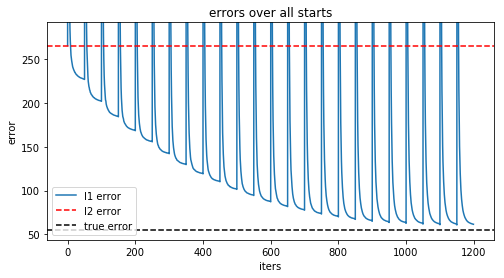

In [5]:
# plotting error over iters
l2_sum_err = np.abs(E_l2).sum()
true_err = np.abs(E).sum()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(errs, label='l1 error')
ax.axhline(l2_sum_err, color='r', linestyle='--', label='l2 error')
ax.axhline(true_err, color='k', linestyle='--', label='true error')
ax.set(xlabel='iters', ylabel='error', title='errors over all starts',
      ylim=(true_err-(true_err/5), l2_sum_err+(l2_sum_err/10)))
plt.legend()
plt.show()

In [6]:
# comparison with original Groenen et al. method
T_l1_unper, E_l1_unper, errs_unper = warm_start_IRLS(100, X, Y, T_l2, lowest_err, perturb=False)

curr err:	261.01903642837635
curr err:	260.8875280866163
curr err:	257.01536247326777
curr err:	256.3468838905809
curr err:	254.0874954328999
curr err:	252.86688772609625
curr err:	251.71570855227264
curr err:	248.6241069224828
curr err:	246.28276256874753
curr err:	244.3148638398985
curr err:	243.13003039059203
increase err:	248.39872619653448
curr err:	243.08903490594994
small decrease in error. stopping.


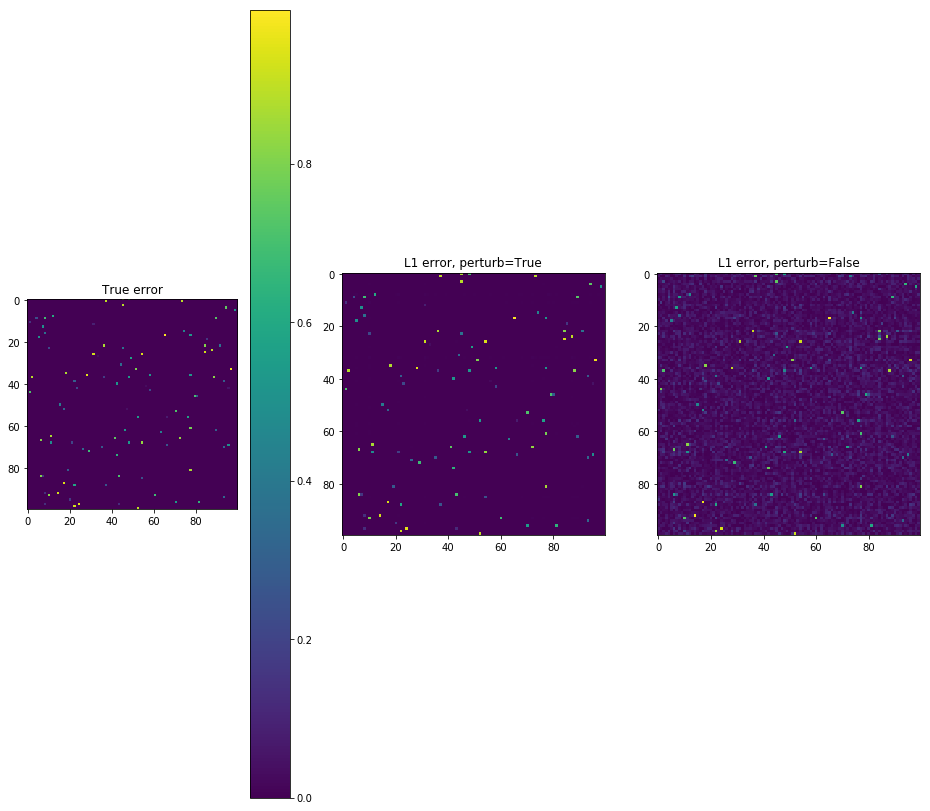

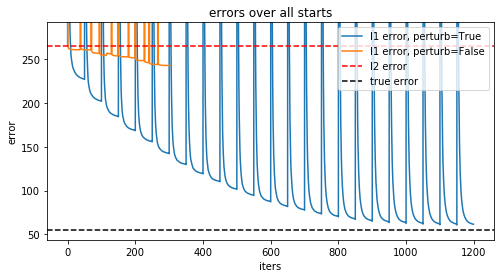

In [7]:
# visualizing their error vs our error
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
im = ax[0].imshow(np.abs(E)) 
fig.colorbar(im, ax=ax[0])
ax[0].set(title='True error')

im = ax[1].imshow(np.abs(E_l1_lowest))
# fig.colorbar(im, ax=ax[1])
ax[1].set(title='L1 error, perturb=True')

im = ax[2].imshow(np.abs(E_l1_unper))
# fig.colorbar(im, ax=ax[2])
ax[2].set(title='L1 error, perturb=False')


fig, ax = plt.subplots(figsize=(8,4))
ax.plot(errs, label='l1 error, perturb=True')
ax.plot(errs_unper[errs_unper != 0], label='l1 error, perturb=False')
ax.axhline(l2_sum_err, color='r', linestyle='--', label='l2 error')
ax.axhline(true_err, color='k', linestyle='--', label='true error')
ax.set(xlabel='iters', ylabel='error', title='errors over all starts',
      ylim=(true_err-(true_err/5), l2_sum_err+(l2_sum_err/10)))
plt.legend(loc=1)
plt.show()

plt.show()